In [1]:
from utils import *

In [2]:
root_path = generate_root_path()

## Creating model

In [3]:
def calc_acc(labels, predicted):
    '''
    Calculating mean class error, e.g. predicted classes are 1vs0, 0vs0, 0vs0, 0vs0, then we have acc=0.25
    Inputs: 
        labels = target labels
        predicted = predicted binary probability distribution for the input
    Output:
        mean class error
    '''
    acc = np.sum(np.array(labels) == np.argmax(np.array(predicted), axis=1)) / len(labels)
    return np.round(acc * 100, 2)

In [4]:
#creating feature extractors
model_gap = model_inceptionresnet_multigap()
model_cnn = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",trainable=False) ])

#creating dense and loading the weights
model = fc_model_softmax(input_num=5000) #if need to use pca change input_num = 9744
weights_path = f'models/Softmax/Multigap_CNN/best_solution_GA_custom.hdf5' #if need to use pca change weights_path = 'models/Softmax/Multigap_CNN/model_fc_softmax_MG_8k_B7_1k_600x600.hdf5'
model.load_weights(weights_path)

In [5]:
indxs = np.load('models/Indices/best_solution.npy')


###  Loading PCA models

In [6]:
pca_mg_path = None#if need to use pca change pca_mg_path = 'models/PCA/PCA_MultiGap_8464_auto.pkl'
pca_cnn_path = None#if need to use pca change pca_cnn_path = 'models/PCA/PCA_CNN_1280_auto.pkl'

#for pca uncomment this
pca_mg = None#pk.load(open(pca_mg_path,'rb')) 
pca_cnn =  None#pk.load(open(pca_cnn_path,'rb'))

## Giving path of folder

In [7]:
#loading paths of benchmark data
good_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'benchmark', 'images', 'good', '*'))
bad_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'benchmark', 'images', 'bad', '*'))

good_alm_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'alm', 'splitted', 'alm_bench', 'images', 'good', '*'))
bad_alm_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'alm', 'splitted', 'alm_bench', 'images', 'bad', '*'))

good_rand_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'Sven_custom_data', 'images', 'good', '*'))
bad_rand_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'Sven_custom_data', 'images', 'bad', '*'))

bad_coco_imgs_path = glob(os.path.join(root_path, 'Data', 'AesthAI', 'Coco', 'images', 'bad', '*'))

#cretae labels for loaded benchmark datas
paths_bench = good_imgs_path + bad_imgs_path
labels_bench = np.concatenate((np.ones(len(good_imgs_path)), np.zeros(len(bad_imgs_path))))

paths_alm_bench = good_alm_imgs_path + bad_alm_imgs_path
labels_alm_bench = np.concatenate((np.ones(len(good_alm_imgs_path)), np.zeros(len(bad_alm_imgs_path))))

paths_rand_bench = good_rand_imgs_path + bad_rand_imgs_path
labels_rand_bench = np.concatenate((np.ones(len(good_rand_imgs_path)), np.zeros(len(bad_rand_imgs_path))))

paths_coco_bench = bad_coco_imgs_path
labels_coco_bench = np.zeros(len(bad_coco_imgs_path))

## Prediction on benchmark

In [8]:
#resize_max (996, 996) means if images' height or width > 996 then resize with maximum 996 and another with aspect ratio
predicted = predict_from_path(model_gap, model, paths_bench, resize_func=resize_max, 
                              size=(996, 996), model_cnn=model_cnn, is_norm=False, 
                              pca_mg = pca_mg, pca_cnn = pca_cnn, take=indxs)

In [9]:
acc = calc_acc(labels_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 93.19 %


In [10]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_bench, pred)

Precision: 95.81 %
Recall: 90.53 %


## Prediction on Coco

In [11]:
predicted = predict_from_path(model_gap, model, paths_coco_bench, resize_func=resize_max, 
                              size=(996, 996), for_all=True,model_cnn=model_cnn, is_norm=False, 
                              pca_mg = pca_mg, pca_cnn = pca_cnn, take=indxs)

In [12]:
acc = calc_acc(labels_coco_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 99.7 %


## Prediction on alm benchmark

In [13]:
predicted = predict_from_path(model_gap, model, paths_alm_bench, resize_func=resize_max, 
                              size=(996, 996), model_cnn=model_cnn, is_norm=False, 
                              pca_mg = pca_mg, pca_cnn = pca_cnn, take=indxs)

In [14]:
acc = calc_acc(labels_alm_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 97.0 %


In [15]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_alm_bench, pred)

Precision: 97.96 %
Recall: 96.0 %


## Prediction on Sven custom data

In [16]:
predicted = predict_from_path(model_gap, model, paths_rand_bench, resize_func=resize_max, 
                              size=(996, 996), model_cnn=model_cnn, is_norm=False, 
                              pca_mg = pca_mg, pca_cnn = pca_cnn, take=indxs)

In [17]:
acc = calc_acc(labels_rand_bench, predicted)
print(f'Accuracy: {acc} %')

Accuracy: 96.0 %


In [18]:
#Precision and Recall
pred = np.argmax(predicted, axis=1)
calc_metrics(labels_rand_bench, pred)

Precision: 96.94 %
Recall: 95.0 %


## Visualizing predictions on benchmark

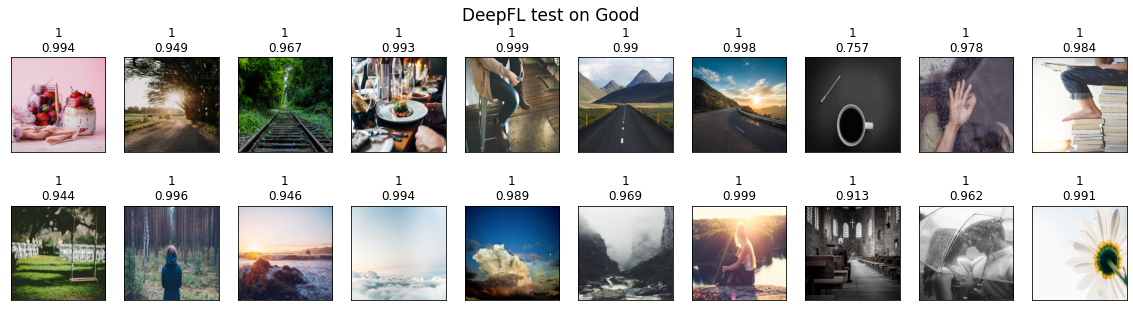

In [19]:
data_size = 20
plot_pred_orig(model_gap, model, good_imgs_path[40:60], resize_func=resize_max, 
               label='Good', size=(996, 996), model_cnn=model_cnn, pca_mg=pca_mg, pca_cnn=pca_cnn, take=indxs)

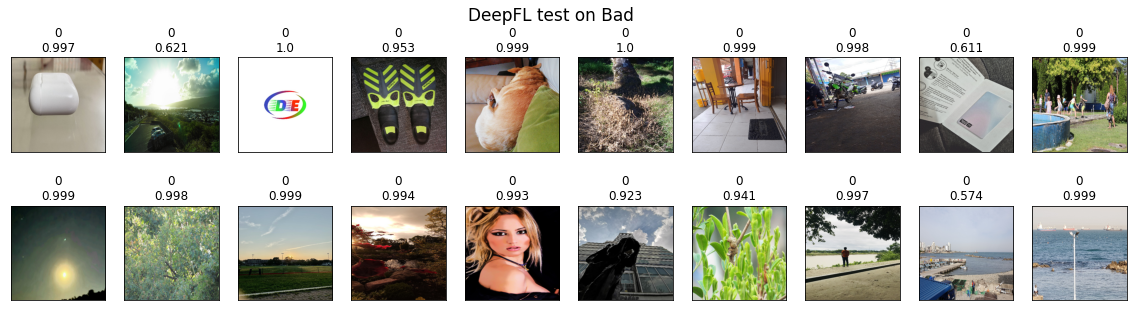

In [20]:
data_size = 20
plot_pred_orig(model_gap, model, bad_imgs_path[60:80], resize_func=resize_max, 
              label='Bad', size=(996, 996), model_cnn=model_cnn, pca_mg=pca_mg, pca_cnn=pca_cnn, take=indxs)

## Visualizing predictions on Coco


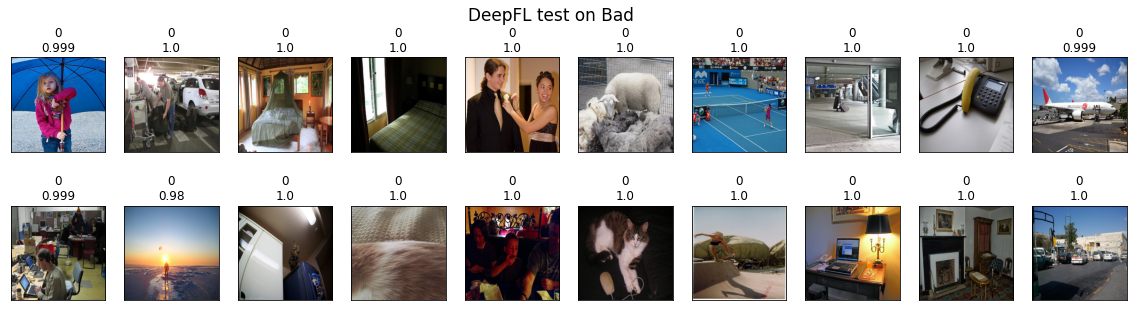

In [21]:
data_size = 20
plot_pred_orig(model_gap, model, bad_coco_imgs_path[data_size:40], resize_func=resize_max, label='Bad',
               size=(996, 996), for_all=True, model_cnn=model_cnn, pca_mg=pca_mg, pca_cnn=pca_cnn, take=indxs)